In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/new_iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

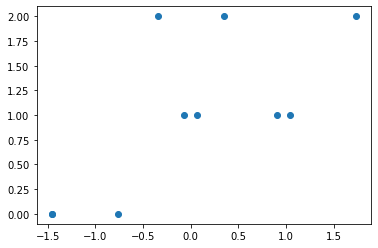

In [8]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
device = torch.device('cpu')
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 10
N_val = 150 - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [126]:
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
num_nodes = 3
net = Net(num_nodes=num_nodes)


print(net)

Net(
  (fc1): Linear(in_features=4, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=3, bias=True)
)


# MF-VI Approx

In [127]:
def compute_categorical_mixture(preds, y):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Categorical(logits=preds.permute(1, 0, 2))
    
    mixture_of_categorical = D.MixtureSameFamily(mix, comp)
    mean_preds = torch.argmax(mixture_of_categorical.component_distribution.probs.mean(1), dim=1).float()
    accuracy = torch.sum(mean_preds == y) / y.shape[0]
    
    ll = mixture_of_categorical.log_prob(y).sum()
    return accuracy, ll

In [128]:
from tqdm.notebook import trange

from models.BNNs.VI_BNN_CLASSIFICTION import VI_BNN
from models.BNNs.pyroBNN_classification import BayesianNeuralNetwork
from pyro.infer.autoguide import AutoDiagonalNormal

In [192]:
alpha = .5
ELBO_BETA = .5

In [193]:
model = BayesianNeuralNetwork(in_features=D_in, prior_var=1./alpha, hidden_nodes=num_nodes, kl_beta=ELBO_BETA)
guide = AutoDiagonalNormal(model)

In [194]:
import pyro
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adamax({"lr": 5e-1})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_iterations = 10000
pyro.clear_param_store()
for j in trange(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))

guide.requires_grad_(False)

params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

  0%|          | 0/10000 [00:00<?, ?it/s]

[iteration 0001] loss: 9.5171
[iteration 1001] loss: 2.8580
[iteration 2001] loss: 2.5765
[iteration 3001] loss: 2.1585
[iteration 4001] loss: 6.6123
[iteration 5001] loss: 3.4002
[iteration 6001] loss: 2.9621
[iteration 7001] loss: 3.4165
[iteration 8001] loss: 3.9614
[iteration 9001] loss: 3.7111


In [195]:
model_loss = 'multi_class_linear_output'

mean, stds = params
# Effect of tau
tau = alpha # Prior Precision
tau_out = 1. # Output Precision

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)


variational_posterior = D.MultivariateNormal(loc=mean, covariance_matrix=torch.diag(stds ** 2))

variational_samps = variational_posterior.sample((10000,))

In [196]:
pred_list_val, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=variational_samps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_val, y_val)

(tensor(0.6643), tensor(-94.6446))

In [197]:
pred_list_train, _ = hamiltorch.predict_model(net, x=x_train, y=y_train, samples=variational_samps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_train, y_train)

(tensor(0.7000), tensor(-6.6053))

In [198]:
prior = D.MultivariateNormal(loc=torch.zeros_like(mean), covariance_matrix = 1./alpha * torch.eye(mean.shape[-1]))
D.kl_divergence(variational_posterior, prior)

tensor(14.5665)

# Compress some weights with variational scheme

In [199]:
#### sample weights with compression algorithm
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser
from tqdm.notebook import trange
coding_sampler = CodingSampler
auxiliary_posterior = VariationalPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.



compute_params_enc =  encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)

n_auxiliaries = compute_params_enc.n_auxiliary
kl_q_p = compute_params_enc.total_kl
var_opt = VariationalOptimiser(compute_params_enc.target, omega, n_auxiliaries, kl_q_p, n_trajectories=16, total_var=1./alpha)
aux_vars = var_opt.run_optimiser(epochs=5000, lr=1e-1)

The mean loss is 7.94443. The mean KL is: 6.54320: 100%|██████████| 5000/5000 [16:05<00:00,  5.18it/s] 


In [200]:
kl_q_p

tensor(14.5665)

In [201]:
initial_seed = 0
beamwidth = 1
epsilon = 0.

compressed_weights_low_eps = []
num_compressed_samples = 500
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_low_eps.append(w[0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [202]:
pred_list_low_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_low_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_low_eps, y_val)

(tensor(0.7571), tensor(-119.6584))

In [203]:
initial_seed = 0
beamwidth = 1
epsilon = 0.1

compressed_weights_var_med_eps = []
num_compressed_samples = 500
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_med_eps.append(w[0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [204]:
pred_list_var_med_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_var_med_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_var_med_eps, y_val)

(tensor(0.6714), tensor(-117.9989))

In [205]:
initial_seed = 0
beamwidth = 1
epsilon = 0.2

compressed_weights_var_high_eps = []
num_compressed_samples = 500
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_high_eps.append(w[0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [206]:
pred_list_var_high_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_var_high_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_var_high_eps, y_val)

(tensor(0.6286), tensor(-114.9382))

In [207]:
# dump the important stuff
import pickle as pkl
pkl.dump(variational_posterior, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_post_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(aux_vars, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_optimised_vars_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(variational_samps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_low_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_var_med_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_var_high_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))